# Simulación de situación base y de posibles soluciones

In [513]:
import json
import pandas as pd
import random
import heapq
from collections import deque, defaultdict
from datetime import datetime
import uuid
from pathlib import Path

class Node:
    def __init__(self, name, mu, servers):
        self.name = name
        self.mu = mu # tasa de servicio de cada servidor
        self.servers = servers # número de servidores
        self.busy = 0 # servidores ocupados
        self.queue = deque() # cola de clientes (pid, tiempo_de_llegada_a_cola)
        # estadísticas
        self.area_q = 0.0 # integral de longitud de cola
        self.area_busy = 0.0 # integral de servidores ocupados
        self.last_event_time = 0.0
        self.num_served = 0 # número de clientes servidos

class Event:
    def __init__(self, time, kind, node_name, pid, external=False):
        self.time = time # instante del evento
        self.kind = kind # 'arrival' o 'departure'
        self.node_name = node_name # nodo donde ocurre
        self.pid = pid # identificador del cliente
        self.external = external # si es llegada externa
    def __lt__(self, other):
        return self.time < other.time

## Función para simular situación base (antes de propuestas de soluciones a problemas)

En un hospital se ha organizado un proceso de atención a pacientes que transitan por diversas etapas. Al llegar al hospital, los pacientes ingresan a una de dos salas de registro, donde esperan su turno para procesar su admisión. Una vez completado el registro, los pacientes pasan a las salas de examinación; cada sala de registro deriva a su correspondiente sala de examinación. En estas salas se evalúa el estado de cada paciente para determinar los siguientes pasos en el proceso de atención médica.

Luego, los pacientes se dirigen a la sala de consulta asociada a la sala de examinación de la que proviene. La consulta incluye también el suministro de medicamentos e indicaciones necesarias para el alta médica. Una vez finalizada la consulta, el paciente finalizó su proceso en el hospital.

Los administradores del hospital buscan principalmente reducir los tiempos de espera de los pacientes.

**Información extra**

Aunque los pacientes llegan de forma aleatoria al hospital, la cantidad de pacientes que llega por hora a cada sala de registro se ha mantenido estable en dos cantidades respectivas de pacientes por hora fija. Esta cantidad puede saberse ya que el hospital registra la fecha y hora en la que cada paciente llega al hospital a esperar su turno para empezar su registro, y también almacena cuándo sale y entra de cada sala; de esta forma también puede saberse cuántos pacientes por hora entran y salen de cada etapa:

1. Sala de registro 1: Llegan 4 pacientes por hora y puede llevar a cabo el registro de 8 pacientes cada hora, en promedio. Cuenta con una sola persona atendiendo.
2. Sala de registro 2: Llegan 3 pacientes por hora y puede registrar 10 pacientes cada hora, en promedio. Cuenta con una sola persona atendiendo.
3. Sala de examinación 1: Los enfermeros pueden atender 6 pacientes cada hora, en promedio. Cuenta con un solo enfermero.
4. Sala de examinación 2: Pueden atender 6 pacientes cada hora, en promedio. Cuenta con un solo enfermero.
5. Sala de consulta 1: Los médicos pueden atender 2.5 pacientes cada hora, en promedio. Cuenta con dos médicos.
6. Sala de consulta 2: Pueden atender 3 pacientes cada hora, en promedio. Cuenta también con dos médicos.

Los administradores del hospital han determinado que cada sala de consulta debe mantenerse ocupada durante menos del 70% del tiempo para evitar que los médicos lleguen a un punto de fatiga excesiva.

In [514]:
def simulate_base(T: float, lambda1: float, lambda2: float, nodes: dict[str, Node]
        ) -> dict[str, dict[str, float]]:
    """
    Simulación base (original) de la situación planteada inicialmente.
    
    Args:
        T: Tiempo de simulación (horas).
        lambda1: Tasa de llegada externa a 'reg1' (pacientes/hora).
        lambda2: Tasa de llegada externa a 'reg2' (pacientes/hora).
        nodes: Diccionario <nombre, Node>
    
    Returns:
        metrics: Diccionario <nombre_nodo, dict<nombre_metrica, float>>
            Explicación de las métricas:
            - Wq: Tiempo promedio en cola (horas).
            - W: Tiempo promedio en el sistema (horas).
            - Lq: Longitud promedio de la cola (número de clientes en cola).
            - L: Longitud promedio del sistema (número de clientes en el sistema).
            - rho: Proporción de tiempo ocupado por los servidores.
            - throughput: Rendimiento (número de clientes atendidos por hora).
    """
    future = []
    t = 0.0
    pid_ctr = 0
    waits = defaultdict(list)

    # primeras llegadas externas a reg1 y reg2
    heapq.heappush(future, Event(random.expovariate(lambda1), 'arrival', 'reg1', pid_ctr, True))
    pid_ctr += 1
    heapq.heappush(future, Event(random.expovariate(lambda2), 'arrival', 'reg2', pid_ctr, True))
    pid_ctr += 1

    while future:
        ev = heapq.heappop(future)
        if ev.time > T:
            break
        # avanzar reloj y actualizar áreas
        dt_global = ev.time - t
        t = ev.time
        for nd in nodes.values():
            nd.area_q += len(nd.queue)*dt_global
            nd.area_busy += nd.busy*dt_global
            nd.last_event_time = t

        node = nodes[ev.node_name]
        if ev.kind == 'arrival':
            # reprogramar siguiente llegada externa
            if ev.external:
                lam = lambda1 if ev.node_name=='reg1' else lambda2
                heapq.heappush(future, Event(t+random.expovariate(lam),
                                             'arrival', ev.node_name, pid_ctr, True))
                pid_ctr += 1
            # si hay servidor libre
            if node.busy < node.servers:
                node.busy += 1
                waits[node.name].append(0.0)
                dt = random.expovariate(node.mu)
                heapq.heappush(future, Event(t+dt, 'departure', node.name, ev.pid))
            else:
                node.queue.append((ev.pid, t))

        else:  # departure
            node.num_served += 1
            node.busy -= 1
            # si hay cola, atiende siguiente
            if node.queue:
                pid_q, t_arr = node.queue.popleft()
                waits[node.name].append(t - t_arr)
                node.busy += 1
                dt = random.expovariate(node.mu)
                heapq.heappush(future, Event(t+dt, 'departure', node.name, pid_q))
            # ruta al siguiente nodo
            if ev.node_name == 'reg1':
                nxt = 'exam1'
            elif ev.node_name == 'reg2':
                nxt = 'exam2'
            elif ev.node_name == 'exam1':
                nxt = 'consult1'
            elif ev.node_name == 'exam2':
                nxt = 'consult2'
            elif ev.node_name.startswith('consult'):
                continue # en consulta sale del sistema
            else:
                raise ValueError(f"Evento de salida inesperado: {ev.node_name}")
            # llegada inmediata
            heapq.heappush(future, Event(t, 'arrival', nxt, ev.pid, False))

    # calcular métricas
    metrics = {}
    for name, nd in nodes.items():
        Lq = nd.area_q / T
        L = nd.area_q / T + nd.area_busy / T
        rho = nd.area_busy / T / nd.servers
        Wq = sum(waits[name]) / len(waits[name]) if waits[name] else 0.0
        W = L / (nd.num_served / T) if nd.num_served > 0 else 0.0
        X   = nd.num_served / T
        metrics[name] = {
            'Wq': Wq,
            'W': W,
            'Lq': Lq,
            'L': L,
            'rho': rho,
            'throughput': X
        }
    return metrics

## (Habían más diseños del problema que después se eliminaron porque no se centraban en las instrucciones de la profesora)

## Simular situación de la solución 3

En la situación base, la sala de examinación 1 siempre dirige a la sala de consulta 1 y la sala de examinación 2 siempre dirige a la sala de consulta 2. 

En lugar de hacer estas direcciones, se utiliza un enfoque parecido al JSQ (join the shortest queue), pero para simplificar el modelo no se utiliza el JSQ como tal (que implica dirigir dinámicamente la salida a la estación de servicio con cola más corta en el momento), sino sólo su principio de enviar mayor proporción de las salidas de las salas de consulta a la sala de consulta con media de clientes en cola menor ($L_q$).

Para esto, se crea una nueva simulación con los siguientes pasos:


1. Correr la simulación base y extraer $L_{q_{c1}}$ (consulta 1) y $L_{q_{c2}}$ (consulta 2).
2. Definir probabilidades de enrutamiento fijas $p_{c1}$ = $\frac{L_{q_{c2}}}{L_{q_{c1}}+L_{q_{c2}}}, p_{c2}$ = $\frac{L_{q_{c1}}}{L_{q_{c1}}+L_{q_{c2}}}$ (envías más flujo al nodo que tenía menor cola promedio en la simulación base; hay una probabilidad de $p_{c1}$ de enviar el paciente de la sala de examinación—tanto para la sala 1 como para la sala 2—a la sala de consulta 1).
3. Simular de nuevo con esas probabilidades estáticas ya asignadas.
4. Comparar métricas de desempeño $W$, $L$, $W_q$, $L_q$ y $\rho$ (rho) antes y después.

$p_{c1}$ termina dando 0.1, lo que da un 90% de flujo hacia el consultorio 2. Esto desborda la cantidad de clientes que entran a la estación de servicio comparado con la cantidad que puede atender por hora, por lo que nunca alcanza un estado estable. Por esto, **esta solución no es óptima pero se utiliza en la solución 4 el mismo proceso pero utilizando mu (tasa de servicio) para calcular la probabilidad de enrutamiento**. La solución 4 termina mejorando bastante los tiempos de espera en el consultorio 1 a cambio de un aumento muy pequeño en el consultorio 2.

In [516]:
def simulate_solution3(T: float, lambda1: float, lambda2: float, nodes: dict[str, Node],
        p_to_consult1: float) -> dict[str, dict[str, float]]:
    """
    Simulación de la solución 3: Enviar mayor proporción de pacientes salientes
    de las salas de consultas a la sala de consulta con media de clientes en cola menor.
    
    Args:
        T: Tiempo de simulación (horas).
        lambda1: Tasa de llegada externa a 'reg1' (pacientes/hora).
        lambda2: Tasa de llegada externa a 'reg2' (pacientes/hora).
        nodes: Diccionario <nombre, Node>
    
    Returns:
        metrics: Diccionario <nombre_nodo, dict<nombre_metrica, float>>
            Explicación de las métricas:
            - Wq: Tiempo promedio en cola (horas).
            - W: Tiempo promedio en el sistema (horas).
            - Lq: Longitud promedio de la cola (número de clientes en cola).
            - L: Longitud promedio del sistema (número de clientes en el sistema).
            - rho: Proporción de tiempo ocupado por los servidores.
            - throughput: Rendimiento (número de clientes atendidos por hora).
    """
    future = []
    t = 0.0
    pid_ctr = 0
    waits = defaultdict(list)

    # primeras llegadas externas a reg1 y reg2
    heapq.heappush(future, Event(random.expovariate(lambda1), 'arrival', 'reg1', pid_ctr, True))
    pid_ctr += 1
    heapq.heappush(future, Event(random.expovariate(lambda2), 'arrival', 'reg2', pid_ctr, True))
    pid_ctr += 1

    while future:
        ev = heapq.heappop(future)
        if ev.time > T:
            break
        # avanzar reloj y actualizar áreas
        dt_global = ev.time - t
        t = ev.time
        for nd in nodes.values():
            nd.area_q += len(nd.queue)*dt_global
            nd.area_busy += nd.busy*dt_global
            nd.last_event_time = t

        node = nodes[ev.node_name]
        if ev.kind == 'arrival':
            # reprogramar siguiente llegada externa
            if ev.external:
                lam = lambda1 if ev.node_name=='reg1' else lambda2
                heapq.heappush(future, Event(t+random.expovariate(lam),
                                             'arrival', ev.node_name, pid_ctr, True))
                pid_ctr += 1
            # si hay servidor libre
            if node.busy < node.servers:
                node.busy += 1
                waits[node.name].append(0.0)
                dt = random.expovariate(node.mu)
                heapq.heappush(future, Event(t+dt, 'departure', node.name, ev.pid))
            else:
                node.queue.append((ev.pid, t))

        else:  # departure
            node.num_served += 1
            node.busy -= 1
            # si hay cola, atiende siguiente
            if node.queue:
                pid_q, t_arr = node.queue.popleft()
                waits[node.name].append(t - t_arr)
                node.busy += 1
                dt = random.expovariate(node.mu)
                heapq.heappush(future, Event(t+dt, 'departure', node.name, pid_q))
            # ruta al siguiente nodo
            if ev.node_name == 'reg1':
                nxt = 'exam1'
            elif ev.node_name == 'reg2':
                nxt = 'exam2'
            elif ev.node_name.startswith('exam'):
                # (*Cambio de esta solución*)
                # Routing estático
                nxt = 'consult1' if random.random() < p_to_consult1 else 'consult2'
            elif ev.node_name.startswith('consult'):
                continue # en consulta sale del sistema
            else:
                raise ValueError(f"Evento de salida inesperado: {ev.node_name}")
            # llegada inmediata
            heapq.heappush(future, Event(t, 'arrival', nxt, ev.pid, False))

    # calcular métricas
    metrics = {}
    for name, nd in nodes.items():
        Lq = nd.area_q / T
        L = nd.area_q / T + nd.area_busy / T
        rho = nd.area_busy / T / nd.servers
        Wq = sum(waits[name]) / len(waits[name]) if waits[name] else 0.0
        W = L / (nd.num_served / T) if nd.num_served > 0 else 0.0
        X   = nd.num_served / T
        metrics[name] = {
            'Wq': Wq,
            'W': W,
            'Lq': Lq,
            'L': L,
            'rho': rho,
            'throughput': X
        }
    return metrics

## Simular situación de la solución 4

Para solucionar el problema de $\lambda_{c1} > \mu_{c1}$ de la solución 3, se sigue el mismo proceso sólo que se cambia:

2. Definir probabilidades de enrutamiento fijas $p_{c1}$ = $\frac{\mu_{c1}}{\mu_{c1}+\mu_{c2}}, p_{c2}$ = $\frac{\mu_{c1}}{\mu_{c1}+\mu_{c2}}$ (envías más flujo al nodo que tenía mayor tasa de servicio en la simulación base—cabe recordar que las tasas de servicio son las mismas en la simulación base y en la simulación de la solución 3 y 4).

De esta forma, se calcula la probabilidad no en función de $L_{q}$, sino de la capacidad de servicio de cada consulta. De esta forma, ambas salas quedan equilibradas y estables, pues los $\rho$ terminan siendo iguales en ambas salas de consulta y menores a 1 (como se explica en `Interpretación de los resultados` al final).

Utiliza la misma función de simulación que la solución 3, pues sólo cambia el valor asignado al parámetro `p_to_consult1`.

## Ejecutar simulaciones

In [517]:

def save_simulation(simulation_name: str, run_dir: Path, metrics: dict[str, dict[str, float]], nodes: dict[str, Node],
                    lambda1: float, lambda2: float, T: float, seed: int) -> None:
    # Guardar los resultados de la simulación en runs/{timestamp} {unique_id}/{simulation_name}
    path = run_dir / simulation_name
    path.mkdir(parents=True, exist_ok=True)

    metrics_df = pd.DataFrame(metrics).T
    metrics_df = metrics_df[['Wq', 'Lq', 'rho', 'throughput']].round(3)
    results_path = path / 'simulation_results.csv'
    metrics_df.to_csv(results_path)
    print(f"Resultados de la simulación {simulation_name} guardados en '{results_path}'.")

    params = {
        'seed': seed,
        'nodes': {name: {'mu': node.mu, 'servers': node.servers} for name, node in nodes.items()},
        'lambda1': lambda1,
        'lambda2': lambda2,
        'T': T,
    }
    params_path = path / 'simulation_params.json'
    with params_path.open('w') as f:
        json.dump(params, f, indent=4)
    print(f"Parámetros de la simulación {simulation_name} guardados en '{params_path}'.")

def display_simulation_metrics(simulation_name: str, metrics: dict[str, dict[str, float]]):
    # Convertir los resultados de la simulación en un DataFrame y mostrarlo como una tabla
    df = pd.DataFrame(metrics).T
    # show always 4 decimales even if it's 0.0000
    df = df.style.format(na_rep='0.0000')
    print("Resultados de la simulación:", simulation_name)
    display(df)

### Entradas (*modificable por el usuario*)

In [ ]:
import copy
# Para obtener exactamente los mismos resultados de una run en específico, 
# sólo usa la misma semilla, mismos parámetros y mismos nodos.

# Horas de simulación
T = 100000.0*10
seed = random.randint(1, 100000) # semilla aleatoria
random.seed(seed)
print(f"Semilla aleatoria: {seed}")

# Parámetros de llegada externa (pacientes/hora)
lambda1 = 4.0 # a reg1
lambda2 = 3.0 # a reg2

# Modelo base
nodes_base = {
    'reg1':    Node('reg1',     mu=8.0, servers=1),
    'reg2':    Node('reg2',     mu=10.0, servers=1),
    'exam1':   Node('exam1',    mu=6.0,  servers=1),
    'exam2':   Node('exam2',    mu=6.0,  servers=1),
    'consult1':Node('consult1', mu=2.5,  servers=2),
    'consult2':Node('consult2', mu=3.0,  servers=2),
}

# Modelo solución 3
nodes_solution3 = copy.deepcopy(nodes_base)

# Modelo solución 4
nodes_solution4 = copy.deepcopy(nodes_solution3)

Semilla aleatoria: 64663


### Correr simulaciones

In [519]:
# Uncomment to generate a random seed each time this cell is run
seed = random.randint(1, 100000) # semilla aleatoria
random.seed(seed)
print(f"Semilla aleatoria: {seed}")

# Crear un directorio único dentro de "runs"
timestamp = datetime.now().strftime("%d-%m-%Y %H_%M_%S")
unique_id = uuid.uuid4().hex[:6] # ID único

# Crear la carpeta común usando timestamp y unique_id
run_dir = Path("runs") / f"{timestamp} {unique_id}"
run_dir.mkdir(parents=True, exist_ok=True)

print("------ Simulación base ------")
base_metrics = simulate_base(T, lambda1, lambda2, copy.deepcopy(nodes_base))
display_simulation_metrics("Base", base_metrics)
save_simulation("base", run_dir, base_metrics, nodes_base, lambda1, lambda2, T, seed)

# print("------ Simulación de la solución 3 ------")
# # Utilizar Lq de la simulación base para calcular la proporción de pacientes que van a consult1
# L_q1 = base_metrics['consult1']['Lq']
# L_q2 = base_metrics['consult2']['Lq']
# p_to_consult1 = L_q2 / (L_q1 + L_q2)
# print(f"Proporción de pacientes que van a consult1: {p_to_consult1:.4f}")
# solution3_metrics = simulate_solution3(T, lambda1, lambda2, copy.deepcopy(nodes_solution3), p_to_consult1)
# display_simulation_metrics("Solución 3", solution3_metrics)
# save_simulation("solution3", run_dir, solution3_metrics, nodes_solution3, lambda1, lambda2, T, seed)

print("------ Simulación de la solución 4 ------")
# Utilizar mu de la simulación base para calcular la proporción de pacientes que van a consult1
mu1 = nodes_base['consult1'].mu
mu2 = nodes_base['consult2'].mu
p_to_consult1 = mu1 / (mu1 + mu2)
print(f"Proporción de pacientes que van a consult1: {p_to_consult1:.4f}")
solution4_metrics = simulate_solution3(T, lambda1, lambda2, copy.deepcopy(nodes_solution4), p_to_consult1)
display_simulation_metrics("Solución 3", solution4_metrics)
save_simulation("solution3", run_dir, solution4_metrics, nodes_solution4, lambda1, lambda2, T, seed)



Semilla aleatoria: 22623
------ Simulación base ------
Resultados de la simulación: Base


,Wq,W,Lq,L,rho,throughput
reg1,0.125115,0.250128,0.500632,1.000855,0.500223,4.001376
reg2,0.042616,0.142465,0.127817,0.427293,0.299476,2.999291
exam1,0.332685,0.499265,1.331198,1.997745,0.666547,4.001372
exam2,0.166718,0.333409,0.500037,0.999990,0.499953,2.999291
consult1,0.717739,1.118033,2.871942,4.473664,0.800861,4.001369
consult2,0.110036,0.443028,0.330030,1.328769,0.499369,2.999290


Resultados de la simulación base guardados en 'runs\10-05-2025 15_52_35 a6d15a\base\simulation_results.csv'.
Parámetros de la simulación base guardados en 'runs\10-05-2025 15_52_35 a6d15a\base\simulation_params.json'.
------ Simulación de la solución 4 ------
Proporción de pacientes que van a consult1: 0.4545
Resultados de la simulación: Solución 3


,Wq,W,Lq,L,rho,throughput
reg1,0.124817,0.249858,0.499073,0.999046,0.499972,3.998454
reg2,0.042851,0.142860,0.128513,0.428447,0.299934,2.999072
exam1,0.331088,0.497670,1.323840,1.989909,0.666069,3.998453
exam2,0.165961,0.332512,0.497728,0.997227,0.499499,2.999072
consult1,0.271928,0.672110,0.864961,2.137874,0.636457,3.180842
consult2,0.226407,0.559525,0.864125,2.135528,0.635702,3.816682


Resultados de la simulación solution3 guardados en 'runs\10-05-2025 15_52_35 a6d15a\solution3\simulation_results.csv'.
Parámetros de la simulación solution3 guardados en 'runs\10-05-2025 15_52_35 a6d15a\solution3\simulation_params.json'.


## Calcular manualmente las medidas de desempeño

In [520]:
import math

# Para sistemas M/M/1
def mm1_metrics(lmbda, mu):
    # Utilización
    rho = lmbda / mu
    # Tiempo promedio en cola: Wq = (ρ^2) / [λ(1-ρ)]
    Wq = (rho**2) / (lmbda * (1 - rho))
    # Tiempo promedio en el nodo: W = Wq + 1/μ
    W = Wq + 1/mu
    # Número promedio en cola: Lq = λ * Wq
    Lq = lmbda * Wq
    # Número promedio en el sistema: L = λ * W
    L = lmbda * W
    return Wq, W, Lq, L, rho

def mmc_metrics(lmbda, mu, c):
    # Utilización (por servidor)
    rho = lmbda / (c * mu)
    # Calcular P0 (probabilidad de 0 clientes en el sistema)
    sum_terms = sum([(c * rho)**n / math.factorial(n) for n in range(c)])
    term = (c * rho)**c / (math.factorial(c) * (1 - rho))
    P0 = 1.0 / (sum_terms + term)
    
    # Promedio de clientes en cola (Lq)
    Lq = P0 * ((c * rho)**c) * rho / (math.factorial(c) * ((1 - rho)**2))
    # Tiempo promedio en cola
    Wq = Lq / lmbda
    # Tiempo promedio en el sistema
    W = Wq + 1/mu
    # Número promedio en el sistema
    L = lmbda * W
    return Wq, W, Lq, L, rho, P0

### Caso base

In [521]:
print("Medidas de desempeño (cálculo manual) para el caso base:")

base_metrics_manually = {}

# Nodo reg1: M/M/1 (λ = 4, μ = 10)
Wq, W, Lq, L, rho = mm1_metrics(4, 10)
base_metrics_manually['reg1'] = {'Wq': Wq, 'W': W, 'Lq': Lq, 'L': L, 'rho': rho}

# Nodo reg2: M/M/1 (λ = 3, μ = 10)
Wq, W, Lq, L, rho = mm1_metrics(3, 10)
base_metrics_manually['reg2'] = {'Wq': Wq, 'W': W, 'Lq': Lq, 'L': L, 'rho': rho}

# Nodo exam1: M/M/1 (λ ≈ 4, μ = 6)
Wq, W, Lq, L, rho = mm1_metrics(4, 6)
base_metrics_manually['exam1'] = {'Wq': Wq, 'W': W, 'Lq': Lq, 'L': L, 'rho': rho}

# Nodo exam2: M/M/1 (λ ≈ 3, μ = 6)
Wq, W, Lq, L, rho = mm1_metrics(3, 6)
base_metrics_manually['exam2'] = {'Wq': Wq, 'W': W, 'Lq': Lq, 'L': L, 'rho': rho}

# Nodo consult1: M/M/2 (λ ≈ 4, μ = 2.5, c = 2)
Wq, W, Lq, L, rho, _ = mmc_metrics(4, 2.5, 2)
base_metrics_manually['consult1'] = {'Wq': Wq, 'W': W, 'Lq': Lq, 'L': L, 'rho': rho}

# Nodo consult2: M/M/2 (λ ≈ 3, μ = 3, c = 2)
Wq, W, Lq, L, rho, _ = mmc_metrics(3, 3, 2)
base_metrics_manually['consult2'] = {'Wq': Wq, 'W': W, 'Lq': Lq, 'L': L, 'rho': rho}

df_base_manual = pd.DataFrame(base_metrics_manually).T

display(df_base_manual)

Medidas de desempeño (cálculo manual) para el caso base:


,Wq,W,Lq,L,rho
reg1,0.066667,0.166667,0.266667,0.666667,0.400000
reg2,0.042857,0.142857,0.128571,0.428571,0.300000
exam1,0.333333,0.500000,1.333333,2.000000,0.666667
exam2,0.166667,0.333333,0.500000,1.000000,0.500000
consult1,0.711111,1.111111,2.844444,4.444444,0.800000
consult2,0.111111,0.444444,0.333333,1.333333,0.500000


### Caso de la solución 4

In [522]:
print("Medidas de desempeño (cálculo manual) para la solución 4:")

solution4_metrics_manually = {}

# Nodo reg1: M/M/1 con λ = 4 y μ = 10
Wq, W, Lq, L, rho = mm1_metrics(4, 10)
solution4_metrics_manually['reg1'] = {'Wq': Wq, 'W': W, 'Lq': Lq, 'L': L, 'rho': rho}

# Nodo reg2: M/M/1 con λ = 3 y μ = 10
Wq, W, Lq, L, rho = mm1_metrics(3, 10)
solution4_metrics_manually['reg2'] = {'Wq': Wq, 'W': W, 'Lq': Lq, 'L': L, 'rho': rho}

# Nodo exam1: M/M/1 con λ = 4 y μ = 6
Wq, W, Lq, L, rho = mm1_metrics(4, 6)
solution4_metrics_manually['exam1'] = {'Wq': Wq, 'W': W, 'Lq': Lq, 'L': L, 'rho': rho}

# Nodo exam2: M/M/1 con λ = 3 y μ = 6
Wq, W, Lq, L, rho = mm1_metrics(3, 6)
solution4_metrics_manually['exam2'] = {'Wq': Wq, 'W': W, 'Lq': Lq, 'L': L, 'rho': rho}

# Calcular las probabilidades de enrutar a los consultorios usando las tasas de servicio
mu1 = 2.5  # tasa de servicio en consult1
mu2 = 3.0  # tasa de servicio en consult2
p_consult1 = mu1 / (mu1 + mu2)
p_consult2 = 1 - p_consult1

# Tasa de llegada total a los consultorios: suma de los flujos de exam1 y exam2 (4 + 3)
lambda_total = 7.0
lambda_consult1 = lambda_total * p_consult1
lambda_consult2 = lambda_total * p_consult2

# Nodo consult1: M/M/2 con λ = lambda_consult1, μ = 2.5 y c = 2
Wq, W, Lq, L, rho, P0 = mmc_metrics(lambda_consult1, 2.5, 2)
solution4_metrics_manually['consult1'] = {'Wq': Wq, 'W': W, 'Lq': Lq, 'L': L, 'rho': rho}

# Nodo consult2: M/M/2 con λ = lambda_consult2, μ = 3 y c = 2
Wq, W, Lq, L, rho, P0 = mmc_metrics(lambda_consult2, 3, 2)
solution4_metrics_manually['consult2'] = {'Wq': Wq, 'W': W, 'Lq': Lq, 'L': L, 'rho': rho}

# Ahora, solution4_metrics_manually contiene las métricas calculadas para cada nodo.
print("\nDiccionario de métricas para la solución 4:")
df_solution4_manual = pd.DataFrame(solution4_metrics_manually).T

display(df_solution4_manual)

Medidas de desempeño (cálculo manual) para la solución 4:

Diccionario de métricas para la solución 4:


,Wq,W,Lq,L,rho
reg1,0.066667,0.166667,0.266667,0.666667,0.400000
reg2,0.042857,0.142857,0.128571,0.428571,0.300000
exam1,0.333333,0.500000,1.333333,2.000000,0.666667
exam2,0.166667,0.333333,0.500000,1.000000,0.500000
consult1,0.272222,0.672222,0.866162,2.138889,0.636364
consult2,0.226852,0.560185,0.866162,2.138889,0.636364


## Comparar medidas de desempeño obtenidas con simulaciones y obtenidas manualmente

### Caso base

Métricas de desempeño calculadas manualmente:


,Wq,W,Lq,L,rho
reg1,0.066667,0.166667,0.266667,0.666667,0.400000
reg2,0.042857,0.142857,0.128571,0.428571,0.300000
exam1,0.333333,0.500000,1.333333,2.000000,0.666667
exam2,0.166667,0.333333,0.500000,1.000000,0.500000
consult1,0.711111,1.111111,2.844444,4.444444,0.800000
consult2,0.111111,0.444444,0.333333,1.333333,0.500000



Métricas de desempeño obtenidas en la simulación (Base):


,Wq,W,Lq,L,rho
reg1,0.125115,0.250128,0.500632,1.000855,0.500223
reg2,0.042616,0.142465,0.127817,0.427293,0.299476
exam1,0.332685,0.499265,1.331198,1.997745,0.666547
exam2,0.166718,0.333409,0.500037,0.999990,0.499953
consult1,0.717739,1.118033,2.871942,4.473664,0.800861
consult2,0.110036,0.443028,0.330030,1.328769,0.499369



Diferencias (Simulación - Manual):


,Wq,W,Lq,L,rho
reg1,0.05845,0.08346,0.23397,0.33419,0.10022
reg2,-0.00024,-0.00039,-0.00075,-0.00128,-0.00052
exam1,-0.00065,-0.00074,-0.00214,-0.00226,-0.00012
exam2,0.00005,0.00008,0.00004,-0.00001,-0.00005
consult1,0.00663,0.00692,0.02750,0.02922,0.00086
consult2,-0.00108,-0.00142,-0.00330,-0.00456,-0.00063


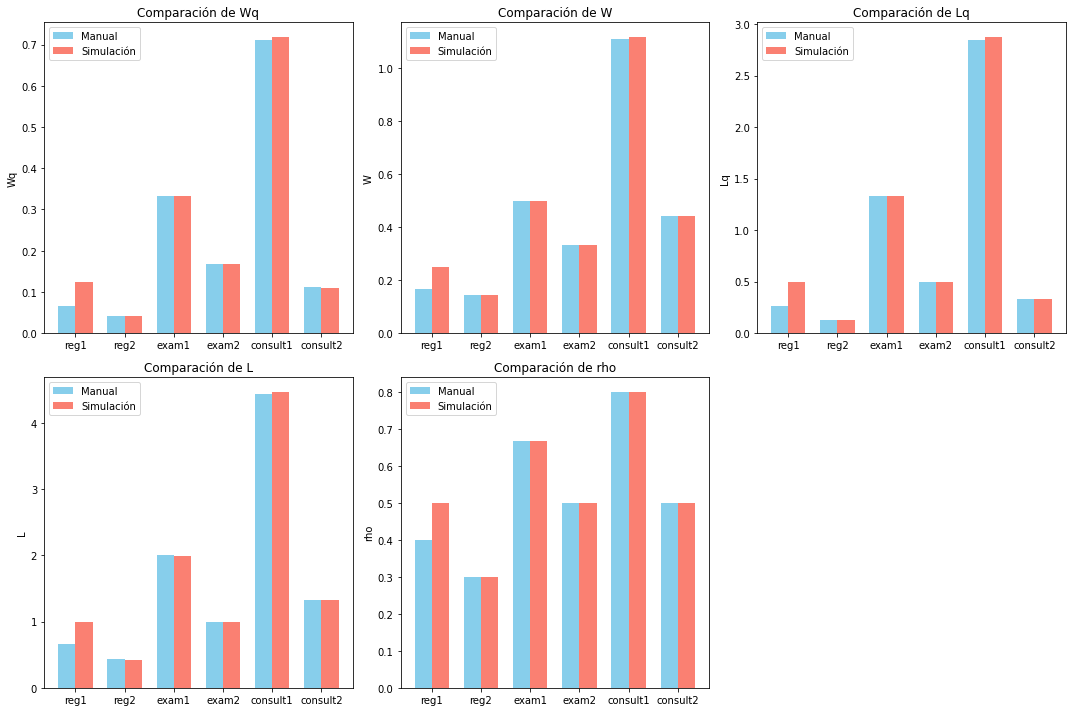

In [523]:
import matplotlib.pyplot as plt

print("Métricas de desempeño calculadas manualmente:")
display(df_base_manual)

# Extraer de base_metrics las métricas simuladas para los mismos nodos
df_simulation = pd.DataFrame(base_metrics).T[['Wq', 'W', 'Lq', 'L', 'rho']]
print("\nMétricas de desempeño obtenidas en la simulación (Base):")
display(df_simulation)

# Crear un DataFrame con la diferencia (Simulación - Manual)
df_diff = (df_simulation - df_base_manual).round(5)
print("\nDiferencias (Simulación - Manual):")
display(df_diff)

# Graficar comparaciones para cada métrica
metric_names = ['Wq', 'W', 'Lq', 'L', 'rho']
nodes = df_base_manual.index.tolist()
x = range(len(nodes))
width = 0.35

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()

for i, metric in enumerate(metric_names):
    ax = axs[i]
    manual_vals = df_base_manual[metric]
    sim_vals = df_simulation[metric]
    ax.bar([p - width/2 for p in x], manual_vals, width=width, label='Manual', color='skyblue')
    ax.bar([p + width/2 for p in x], sim_vals, width=width, label='Simulación', color='salmon')
    ax.set_xticks(x)
    ax.set_xticklabels(nodes)
    ax.set_ylabel(metric)
    ax.set_title(f'Comparación de {metric}')
    ax.legend()

axs[-1].axis('off')

plt.tight_layout()
plt.show()

### Solución 4

Métricas de desempeño calculadas manualmente:


,Wq,W,Lq,L,rho
reg1,0.066667,0.166667,0.266667,0.666667,0.400000
reg2,0.042857,0.142857,0.128571,0.428571,0.300000
exam1,0.333333,0.500000,1.333333,2.000000,0.666667
exam2,0.166667,0.333333,0.500000,1.000000,0.500000
consult1,0.272222,0.672222,0.866162,2.138889,0.636364
consult2,0.226852,0.560185,0.866162,2.138889,0.636364



Métricas de desempeño obtenidas en la simulación (Base):


,Wq,W,Lq,L,rho
reg1,0.124817,0.249858,0.499073,0.999046,0.499972
reg2,0.042851,0.142860,0.128513,0.428447,0.299934
exam1,0.331088,0.497670,1.323840,1.989909,0.666069
exam2,0.165961,0.332512,0.497728,0.997227,0.499499
consult1,0.271928,0.672110,0.864961,2.137874,0.636457
consult2,0.226407,0.559525,0.864125,2.135528,0.635702



Diferencias (Simulación - Manual):


,Wq,W,Lq,L,rho
reg1,0.05815,0.08319,0.23241,0.33238,0.09997
reg2,-0.00001,0.00000,-0.00006,-0.00012,-0.00007
exam1,-0.00225,-0.00233,-0.00949,-0.01009,-0.00060
exam2,-0.00071,-0.00082,-0.00227,-0.00277,-0.00050
consult1,-0.00029,-0.00011,-0.00120,-0.00101,0.00009
consult2,-0.00044,-0.00066,-0.00204,-0.00336,-0.00066


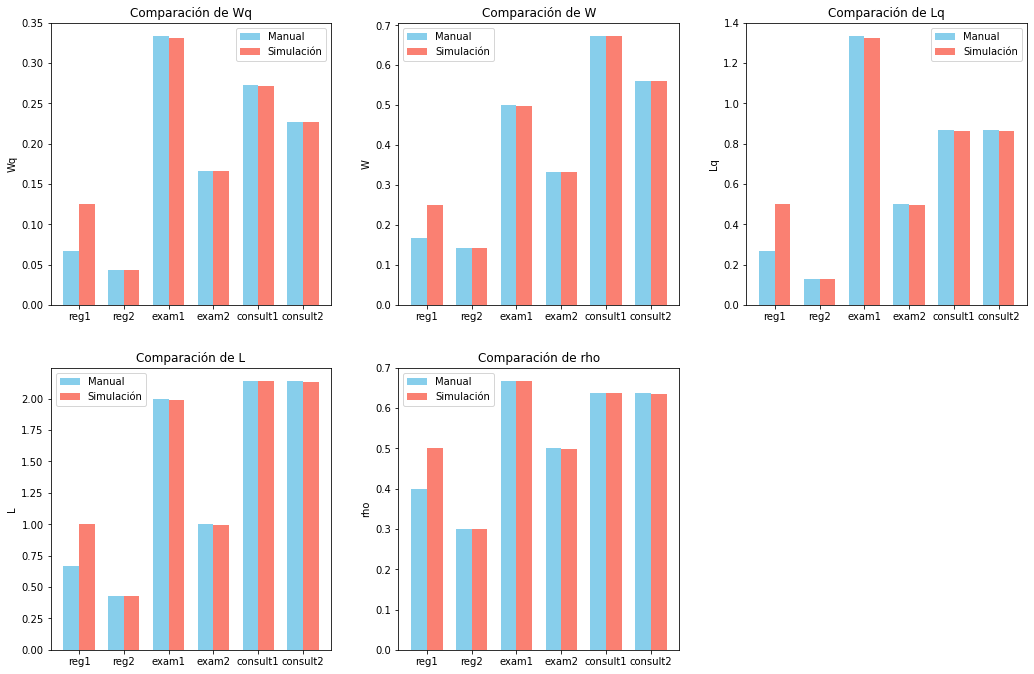

In [524]:
print("Métricas de desempeño calculadas manualmente:")
display(df_solution4_manual)

# Extraer de base_metrics las métricas simuladas para los mismos nodos
df_simulation = pd.DataFrame(solution4_metrics).T[['Wq', 'W', 'Lq', 'L', 'rho']]
print("\nMétricas de desempeño obtenidas en la simulación (Base):")
display(df_simulation)

# Crear un DataFrame con la diferencia (Simulación - Manual)
df_diff = (df_simulation - df_solution4_manual).round(5)
print("\nDiferencias (Simulación - Manual):")
display(df_diff)

# Graficar comparaciones para cada métrica
metric_names = ['Wq', 'W', 'Lq', 'L', 'rho']
nodes = df_solution4_manual.index.tolist()
x = range(len(nodes))
width = 0.35

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()

for i, metric in enumerate(metric_names):
    ax = axs[i]
    manual_vals = df_solution4_manual[metric]
    sim_vals = df_simulation[metric]
    ax.bar([p - width/2 for p in x], manual_vals, width=width, label='Manual', color='skyblue')
    ax.bar([p + width/2 for p in x], sim_vals, width=width, label='Simulación', color='salmon')
    ax.set_xticks(x)
    ax.set_xticklabels(nodes)
    ax.set_ylabel(metric)
    ax.set_title(f'Comparación de {metric}')
    ax.legend()

axs[-1].axis('off')

plt.tight_layout(pad=3.0)  # Ajustar el diseño para evitar que las gráficas se corten
plt.show()

## Comparar medidas de desempeño de la solución 4 y el caso base para ver si hay mejora en los tiempos

=== Comparativa Base vs Solución 4 ===


Base                                                     \
                Wq         W        Lq         L       rho throughput   
reg1      0.125115  0.250128  0.500632  1.000855  0.500223   4.001376   
reg2      0.042616  0.142465  0.127817  0.427293  0.299476   2.999291   
exam1     0.332685  0.499265  1.331198  1.997745  0.666547   4.001372   
exam2     0.166718  0.333409  0.500037  0.999990  0.499953   2.999291   
consult1  0.717739  1.118033  2.871942  4.473664  0.800861   4.001369   
consult2  0.110036  0.443028  0.330030  1.328769  0.499369   2.999290   

              Sol4                                                     
                Wq         W        Lq         L       rho throughput  
reg1      0.124817  0.249858  0.499073  0.999046  0.499972   3.998454  
reg2      0.042851  0.142860  0.128513  0.428447  0.299934   2.999072  
exam1     0.331088  0.497670  1.323840  1.989909  0.666069   3.998453  
exam2     0.165961  0.332512  0.497728  0.997227  0.499499   2.999072  
consult1  0.271928  0.672110  0.864961  2.137874  0.636457   3.180842  
consult2  0.226407  0.559525  0.864125  2.135528  0.635702   3.816682


=== Diferencias absolutas (Base - Sol4) ===


,Wq,W,Lq,L,rho,throughput
reg1,0.0003,0.0003,0.0016,0.0018,0.0003,0.0029
reg2,-0.0002,-0.0004,-0.0007,-0.0012,-0.0005,0.0002
exam1,0.0016,0.0016,0.0074,0.0078,0.0005,0.0029
exam2,0.0008,0.0009,0.0023,0.0028,0.0005,0.0002
consult1,0.4458,0.4459,2.0070,2.3358,0.1644,0.8205
consult2,-0.1164,-0.1165,-0.5341,-0.8068,-0.1363,-0.8174



=== Mejora porcentual (%) ===


,Wq,W,Lq,L,rho,throughput
reg1,0.24,0.11,0.31,0.18,0.05,0.07
reg2,-0.55,-0.28,-0.54,-0.27,-0.15,0.01
exam1,0.48,0.32,0.55,0.39,0.07,0.07
exam2,0.45,0.27,0.46,0.28,0.09,0.01
consult1,62.11,39.88,69.88,52.21,20.53,20.51
consult2,-105.76,-26.30,-161.83,-60.71,-27.30,-27.25


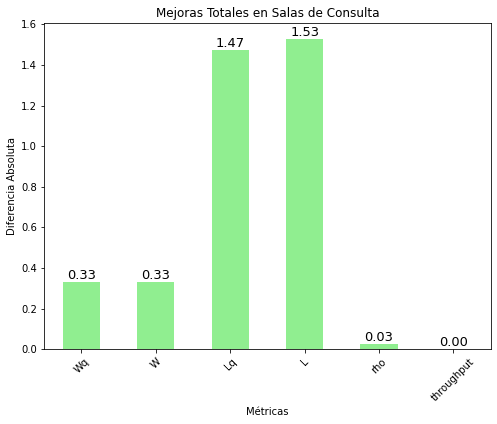

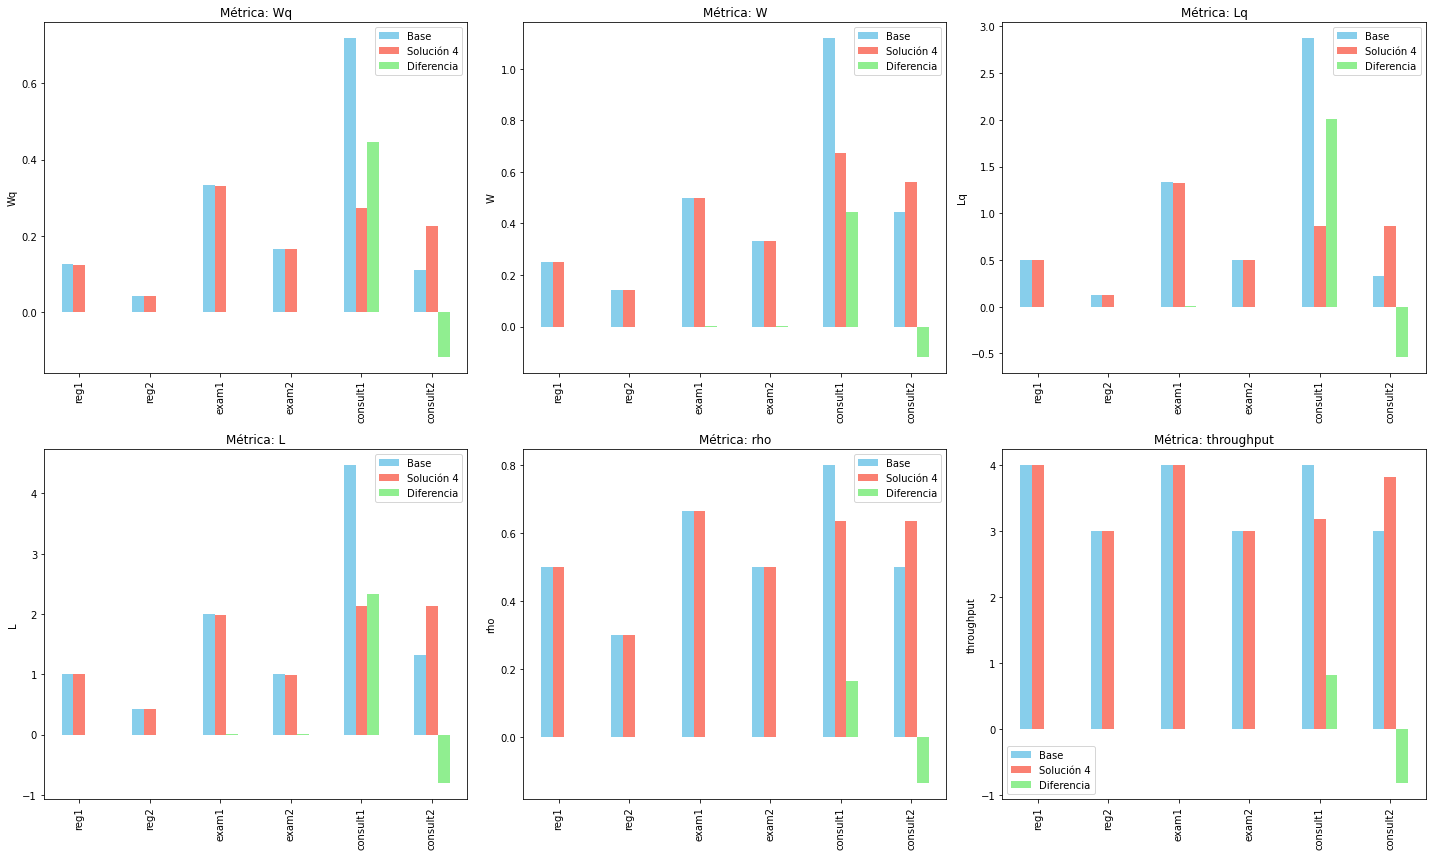

In [525]:
# Convertir los dict de métricas a DataFrames
df_base = pd.DataFrame(base_metrics).T
df_sol4 = pd.DataFrame(solution4_metrics).T

# Combinar Base vs Solución 4 en un solo DataFrame con MultiIndex
df_combined = pd.concat({'Base': df_base, 'Sol4': df_sol4}, axis=1)

# Calcular diferencias absolutas y relativas (porcentaje de mejora)
df_diff = df_combined['Base'] - df_combined['Sol4']
df_pct  = (df_diff / df_combined['Base']) * 100

# Calcular mejora total en salas de consulta (suma de diferencias absolutas)
df_total_diff = df_diff.loc[['consult1', 'consult2']].sum(axis=0)

# Mostrar tablas
print("=== Comparativa Base vs Solución 4 ===")
display(df_combined)

print("\n=== Diferencias absolutas (Base - Sol4) ===")
display(df_diff.round(4))

print("\n=== Mejora porcentual (%) ===")
display(df_pct.round(2))

# Graficar mejoras totales
plt.figure(figsize=(8, 6))
ax = df_total_diff.plot(kind='bar', color='lightgreen')
plt.title('Mejoras Totales en Salas de Consulta')
plt.xlabel('Métricas')
plt.ylabel('Diferencia Absoluta')
plt.xticks(rotation=45)

# Mostrar el valor encima de cada barra
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=13, color='black')

# Graficar métricas por nodo (Base vs Sol4)
metrics = ['Wq','W','Lq','L','rho','throughput']

fig, axes = plt.subplots(2, 3, figsize=(20, 12))  # Aumentar el tamaño de la figura
axes = axes.flatten()

# Concatenar combined y diff para graficar
df_plot = pd.concat({'Base': df_base, 'Sol4': df_sol4, 'Diff': df_diff}, axis=1)

for ax, metric in zip(axes, metrics):
    # Extraer las tres columnas (Base, Sol4 y Diff) para la métrica actual
    df_plot_metric = df_plot.loc[:, (slice(None), metric)]
    # Quitar el nivel de índice de columna que sobra
    df_plot_metric.columns = df_plot_metric.columns.droplevel(1)
    df_plot_metric.plot(kind='bar', ax=ax, color=['skyblue', 'salmon', 'lightgreen'])
    ax.set_title(f"Métrica: {metric}")
    ax.set_ylabel(metric)
    ax.legend(['Base', 'Solución 4', 'Diferencia'])

plt.tight_layout()
plt.show()


### Interpretación de los resultados

Al permitir que los pacientes de las salas de examinación se dirijan hacia alguno de los dos consultorios por medio de probabilidades de enrutamiento, $\rho$ toma el mismo valor en el consultorio 1 y en el consultorio 2 (pues el flujo de salida de las salas de examinación se dirige de forma proporcional a las tasas de servicio de los consultorios; es como si se tuviera un $\lambda = 4+3 = 7$ total, que el porcentaje $\mu_{1} / (\mu_{1} + \mu_{2})$ se asigna al consultorio 1, quendado $\lambda_{c1} = \frac{\mu_{1}}{\mu_{1} + \mu_{2}} \rightarrow \rho_{c1} = \frac{1}{\mu_{1} + \mu_{2}}$; para el consultorio 2 se realiza el mismo cálculo y termina $\lambda_{c2} = \frac{\mu_{2}}{\mu_{1} + \mu_{2}} \rightarrow \rho_{c2} = \frac{1}{\mu_{1} + \mu_{2}} = \rho_{c1}$). Esto es un indicador de que ambas estaciones de servicio tienen la misma fracción esperada de tiempo que los servidores individuales están ocupados. Los tiempos de espera se reducen mucho para el consultorio 1 y aumentan muy poco en el consultorio 2; lo mismo pasa para la cantidad de pacientes esperando en fila; la cantidad de pacientes siendo atendidos en consultorios se mantiene prácticamente igual (pues $\rho = L - L_q$ (cantidad media de clientes en servicio en cualquier instante) del consultorio 1 baja pero $\rho$ del consultorio 2 aumenta casi en la misma cantidad). 

# Después de terminar la Notebook

* **Podría implementarse una solución 5** después de la solución 4 juntando exam1 y exam2 a un solo nodo con dos servidores y cola compartida (dos instalaciones de servicio separadas que realizan la misma función con la misma tasa de servicio son menos eficientes que una sola instalación de servicio con dos servidores); **pero tomaría algo más de tiempo, así que puede que no sea necesario**.

* **Calcular todas las medidas de desempeño manualmente** utilizando las fórmulas del Hillier Lieberman para cada nodo. Cómo se calculan los $\lambda$ de cada nodo se puede ver fácilmente en https://www.youtube.com/watch?v=OkHWnTHaOzY. Con tener los $\lambda$ de cada nodo, los $\mu$ ya se dan en la celda que define los nodos en los datos de entrada antes de correr la simulación. Anotar los resultados de cada nodo del sistema base y del sistema de la solución 4. No hace falta escribirse todo el desarrollo de las fórmulas; sólo anotar la fórmula general, sustituir datos y poner directo el resultado final (porque esto lo calculamos con las funciones mm1_metrics y mms_metrics, no hace falta hacerse a mano el cálculo).

* **Comparar con los datos obtenidos en la simulación**: los resultados son prácticamente los mismos. Si acaso hay una diferencia menor a 0.01 en cada resultado.

* **Escribir la interpretación de resultados en el Word**.

* **Escribir la introducción, descripción, etc.**

```
 Presentación del proyecto final  
El proyecto final se presentará como:
 
• Presentación / Documento
Es preferible tener una presentación para apoyarse en el momento de las
exposiciones, sin embargo, se puede presentar solamente el documento con la
información referente al proyecto.
 
El tema del proyecto es Teoría de colas por lo que se espera una introducción al tema,
la descripción del modelo a utilizar, con todos los parámetros, al menos una
representación visual (gráfica) de la situación en la que se basa el proyecto y resolver
alguna situación o buscar mejorar los tiempos de atención al cliente o la reducción
de los tiempos de espera.
 
Deberá presentarse el análisis del sistema de colas, explicando que es y que
representa en el contexto a tratar  
o Fuente de entrada  
o Variables utilizadas, parámetros
o Tipo de población  
o Tasa de llegada  
o Mecanismo de servicio  
o Disciplina de la cola
o Tiempos de espera
o Longitud de cola  
o Disciplina de servicio
o Distribución de salida
 
• Exposición  
Cada uno de los integrantes del equipo deberá tener una participación mínima de 3
minutos. En total la participación de cada equipo deberá durar entre 10 y 15 minutos,
en donde se explicará el contenido del documento/presentación, así como el código
utilizado y deberán ser capaces de responder preguntas realizadas por sus
compañeros y docente.
 
• Código  
Solver comercial (Python o R), donde se trabajó la base de datos para simular
llegadas y salidas al sistema de colas, además del efecto de la solución propuesta,
así como la comparación de ambos sistemas.
*Se podrán hacer ajustes a las indicaciones en caso de que se requiera especificar
algo más.
```
